<div style="background-color: #212121; padding: 25px; border-radius: 15px; border-left: 10px solid #00e676; box-shadow: 0px 4px 10px rgba(0,0,0,0.3);"> 
    <h1 style="color: #ffffff; margin-bottom: 5px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">MindSchedule: Advanced Intent Classification</h1> 
    <p style="font-size: 1.2em; color: #b0bec5;">Riset Perbandingan Multimodel NLP untuk Chatbot Kesehatan Mental & Akademik Mahasiswa</p> 
    <hr style="border: 0.5px solid #424242;"> 
    <strong style="color: #00e676;">Tujuan Proyek:</strong> Eksperimen & Pemodelan AI (Final Report)
</div>

## 1. Problem Definition (Poin 5a)
**Masalah:** Tekanan akademik seringkali berujung pada kelelahan mental. Mahasiswa membutuhkan asisten yang tidak hanya mengatur jadwal tetapi juga memahami kondisi psikologis mereka.

**Solusi:** Implementasi Chatbot dengan Intent Classification untuk membedakan kebutuhan bantuan jadwal (Akademik) dan kebutuhan dukungan emosional (Kesehatan Mental).

In [1]:
# [1] IMPORT LIBRARY LENGKAP
import pandas as pd
import numpy as np
import re
import nltk
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Model-model untuk dibandingkan
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

# Styling plot
plt.style.use('dark_background')
print("✅ Library dan Resource Siap!")

c:\Users\faisa\anaconda3\envs\nlp-chatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Library dan Resource Siap!


## 2. Data Collection & Preview (Poin 5b)
Mengambil dataset dari HuggingFace dan menampilkan struktur data mentah.

In [2]:
# Load Dataset
ds_mental = load_dataset("heliosbrahma/mental_health_chatbot_dataset", split="train")
ds_student = load_dataset("bot-remains/student-assistance-chatbot", split="train")

df_mental = pd.DataFrame(ds_mental)
df_student = pd.DataFrame(ds_student)

print("🔍 Preview Data Mental Health:")
display(df_mental.head(3))

print("\n🔍 Preview Data Student Assistance:")
display(df_student.head(3))

🔍 Preview Data Mental Health:


,text
0,<HUMAN>: What is a panic attack?\n<ASSISTANT>:...
1,<HUMAN>: What are symptoms of panic attack vs....
2,<HUMAN>: What are the types of Mental Illness?...



🔍 Preview Data Student Assistance:


,category,instruction,input,output
0,Greetings and Farewells,Respond to greetings and farewells.,"Hi, how are you?","Hello! I'm doing great, thank you. How about you?"
1,Greetings and Farewells,Respond to greetings and farewells.,"Goodbye, see you later!",Goodbye! Take care and see you soon!
2,Greetings and Farewells,Respond to greetings and farewells.,Hi,Hello there! How can I help you today?


## 3. Text Preprocessing: Tahapan (Poin 5c)

### 3.1 Cleansing & Lowercasing Tahap awal: Menghapus simbol dan mengubah teks menjadi huruf kecil.

In [3]:
def cleansing(text):
    text = re.sub(r"[^a-z\s]", "", str(text).lower())
    return text

df_merged = pd.concat([
    df_mental.rename(columns={'text': 'text'})[['text']].assign(intent='mental_health'),
    df_student.rename(columns={'input': 'text'})[['text', 'category']].rename(columns={'category': 'intent'})
], ignore_index=True).dropna()

df_merged["cleansed"] = df_merged["text"].apply(cleansing)
display(df_merged[["text", "cleansed"]].head(5))

,text,cleansed
0,<HUMAN>: What is a panic attack?\n<ASSISTANT>:...,human what is a panic attack\nassistant panic ...
1,<HUMAN>: What are symptoms of panic attack vs....,human what are symptoms of panic attack vs anx...
2,<HUMAN>: What are the types of Mental Illness?...,human what are the types of mental illness\nas...
3,<HUMAN>: What does mental-illness mean?\n<ASSI...,human what does mentalillness mean\nassistant ...
4,<HUMAN>: How can you treat mental illness?\n<A...,human how can you treat mental illness\nassist...


### 3.2 Stopword Removal & Lemmatization
**Tahap Menengah:** Pada tahap ini, kita membuang kata-kata umum yang tidak memberikan makna (Stopwords) seperti 'the', 'is', 'at', dan mengembalikan kata ke bentuk dasarnya (Lemmatization) agar 'studying' atau 'studies' menjadi 'study'.

In [4]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def final_preprocess(text):
    words = str(text).split()
    # Proses filtering dan lemmatizing dalam satu baris
    return " ".join([lemmatizer.lemmatize(w) for w in words if w not in stop_words])

# Membuat kolom baru: final_text
df_merged["final_text"] = df_merged["cleansed"].apply(final_preprocess)

print("✅ Kolom 'final_text' Berhasil Dibuat!")
# Menampilkan perbandingan hasil akhir preprocessing
display(df_merged[["cleansed", "final_text"]].head(10))

✅ Kolom 'final_text' Berhasil Dibuat!


,cleansed,final_text
0,human what is a panic attack\nassistant panic ...,human panic attack assistant panic attack come...
1,human what are symptoms of panic attack vs anx...,human symptom panic attack v anxiety attack as...
2,human what are the types of mental illness\nas...,human type mental illness assistant many diffe...
3,human what does mentalillness mean\nassistant ...,human mentalillness mean assistant mental illn...
4,human how can you treat mental illness\nassist...,human treat mental illness assistant treatment...
5,human are patients with schizophrenia violent\...,human patient schizophrenia violent assistant ...
6,human how to manage stress\nassistant here are...,human manage stress assistant personalized sug...
7,human my family has no history of mental illne...,human family history mental illness mean immun...
8,human do children have mental health issues\na...,human child mental health issue assistant abso...
9,human what are the side effects of medication\...,human side effect medication assistant like me...


### 3.3 Analisis Kata Terbanyak (Word Cloud)
Visualisasi ini membantu kita memahami topik dominan dalam dataset. Semakin besar ukuran kata, semakin sering kata tersebut muncul.

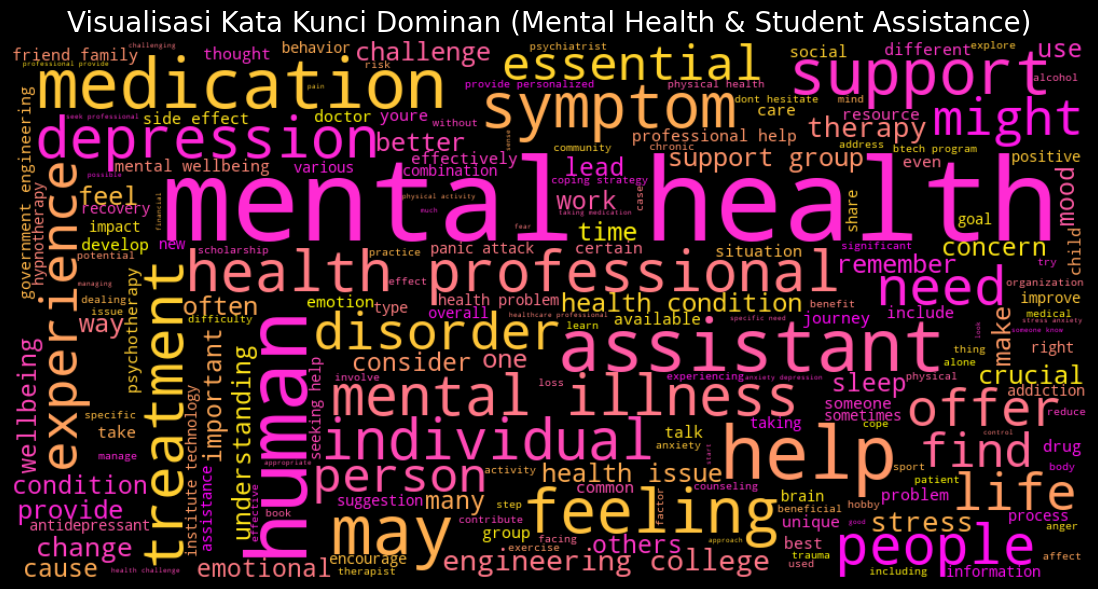

In [5]:
all_words = " ".join(df_merged["final_text"])
wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap='spring').generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Kunci Dominan (Mental Health & Student Assistance)", fontsize=20)
plt.show()

### 3.4 Distribusi Label (Intent)
Sebelum masuk ke pemodelan, kita perlu melihat apakah dataset kita seimbang (balanced) atau tidak antara kategori Mental Health dan kategori Akademik lainnya.

C:\Users\faisa\AppData\Local\Temp\ipykernel_22408\3180339399.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_merged, y='intent', palette='viridis', order=df_merged['intent'].value_counts().index)


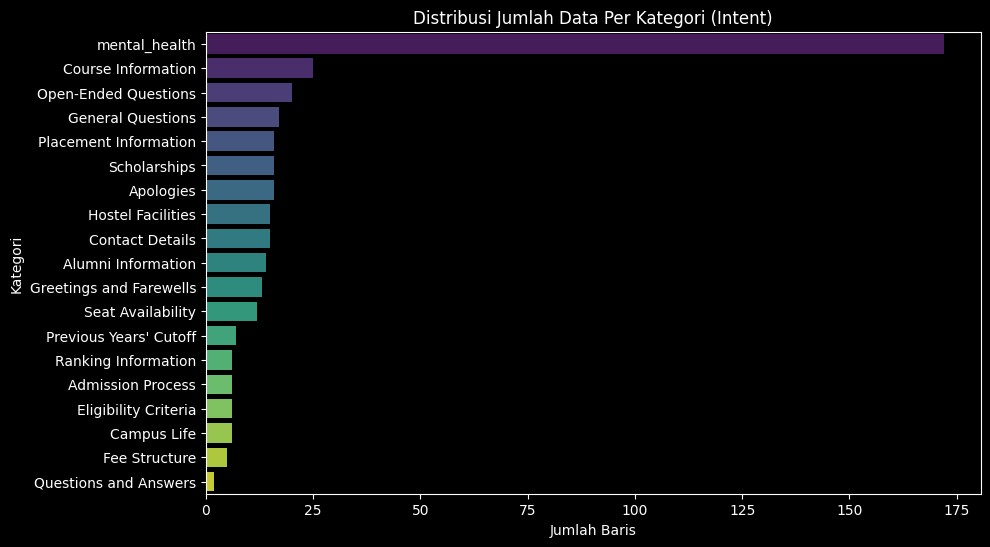

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_merged, y='intent', palette='viridis', order=df_merged['intent'].value_counts().index)
plt.title("Distribusi Jumlah Data Per Kategori (Intent)")
plt.xlabel("Jumlah Baris")
plt.ylabel("Kategori")
plt.show()

## 4. Feature Extraction: TF-IDF (Poin 5d)
**Tahap Transformasi:** Komputer tidak mengerti teks, jadi kita mengubah teks bersih menjadi angka-angka statistik menggunakan TF-IDF (Term Frequency-Inverse Document Frequency).

In [7]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_merged["final_text"])
y = df_merged["intent"]

print(f"✅ Matriks TF-IDF Terbentuk!")
print(f"Total Dokumen: {X.shape[0]}")
print(f"Total Fitur (Kata unik): {X.shape[1]}")

✅ Matriks TF-IDF Terbentuk!
Total Dokumen: 389
Total Fitur (Kata unik): 2671


## 5. Model Training & Comparison (Poin 5e)
Kami membandingkan **3 Arsitektur Model** berbeda untuk melihat mana yang paling akurat dalam mengklasifikasikan niat pengguna.

,Model,Accuracy
0,Logistic Regression,0.730769
1,Random Forest,0.756410
2,Naive Bayes,0.551282


C:\Users\faisa\AppData\Local\Temp\ipykernel_22408\2028491723.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='Model', y='Accuracy', palette='magma')


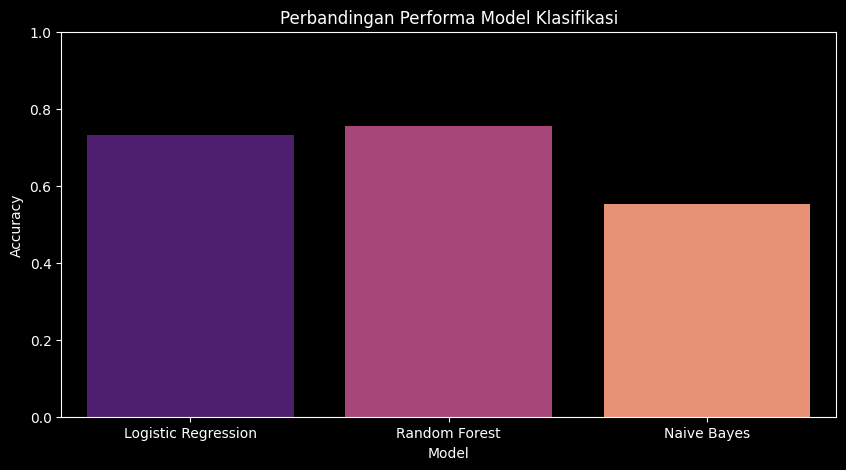

In [8]:
# Split Data 80% Training & 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definisi 3 Model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

# Training dan Scoring
comparison_data = []
for name, model in models.items():
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    comparison_data.append({"Model": name, "Accuracy": acc})

# Menampilkan Tabel Perbandingan
df_results = pd.DataFrame(comparison_data)
display(df_results)

# Visualisasi Perbandingan Akurasi
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x='Model', y='Accuracy', palette='magma')
plt.title("Perbandingan Performa Model Klasifikasi")
plt.ylim(0, 1)
plt.show()

## 6. Evaluation: Detail Metrics (Poin 5f)
Pada tahap ini, kita melakukan analisis mendalam terhadap performa model. Meskipun kita membandingkan tiga model, kita akan melihat lebih detail laporan klasifikasi dari model yang akan kita pilih untuk tahap produksi.

📊 Laporan Klasifikasi Detail untuk Logistic Regression:
                         precision    recall  f1-score   support

      Admission Process       0.00      0.00      0.00         1
     Alumni Information       1.00      1.00      1.00         3
              Apologies       0.00      0.00      0.00         3
            Campus Life       0.00      0.00      0.00         1
        Contact Details       1.00      1.00      1.00         3
     Course Information       0.83      1.00      0.91         5
   Eligibility Criteria       0.00      0.00      0.00         1
          Fee Structure       0.00      0.00      0.00         1
      General Questions       0.00      0.00      0.00         4
Greetings and Farewells       1.00      0.33      0.50         3
      Hostel Facilities       1.00      0.67      0.80         3
   Open-Ended Questions       0.00      0.00      0.00         4
  Placement Information       1.00      1.00      1.00         3
 Previous Years' Cutoff       0.0

c:\Users\faisa\anaconda3\envs\nlp-chatbot\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\faisa\anaconda3\envs\nlp-chatbot\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\faisa\anaconda3\envs\nlp-chatbot\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

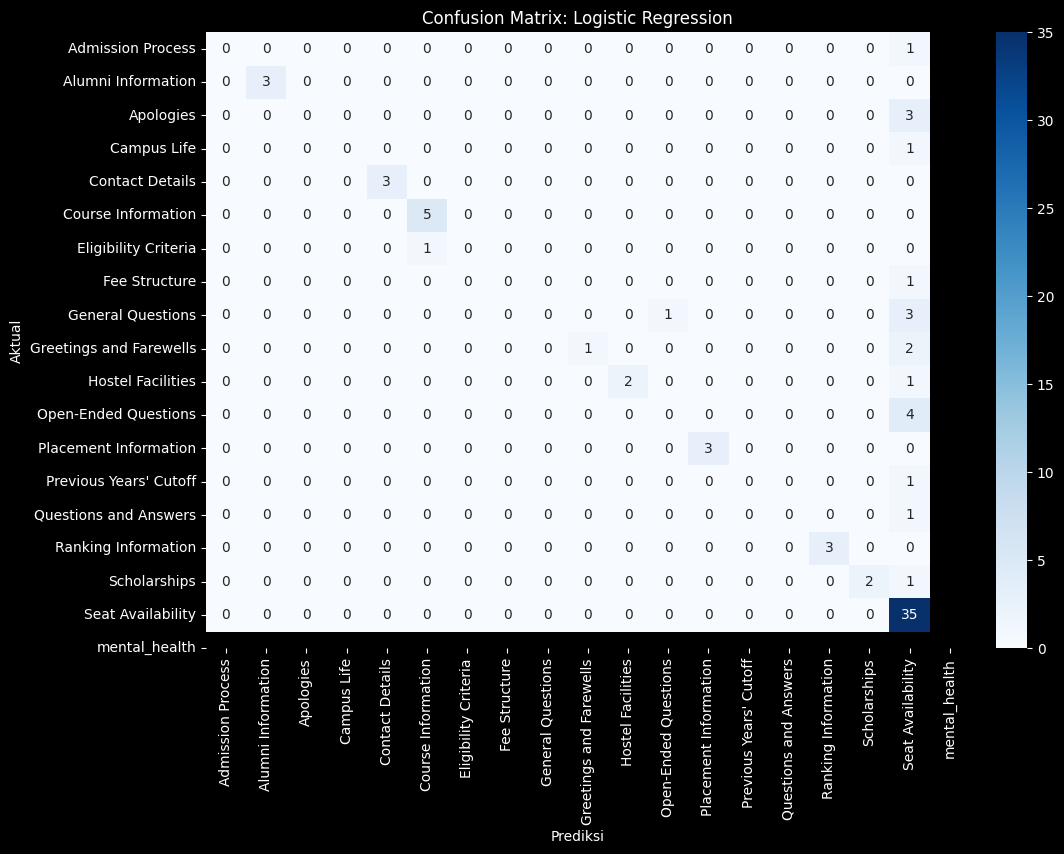

In [11]:
# Memilih model untuk dievaluasi detail (Logistic Regression)
best_model_name = "Logistic Regression"
eval_model = models[best_model_name]
y_pred = eval_model.predict(X_test)

print(f"📊 Laporan Klasifikasi Detail untuk {best_model_name}:")
print(classification_report(y_test, y_pred))

# Confusion Matrix untuk melihat sebaran prediksi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=eval_model.classes_, 
            yticklabels=eval_model.classes_)
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

## 7. Pemilihan Model Final (Poin 6c)
Berdasarkan hasil eksperimen di atas, didapatkan hasil akurasi sebagai berikut:
1. Random Forest: 0.7564 (75.6%)
2. Logistic Regression**: 0.7307 (73.0%)
3. Naive Bayes: 0.5512 (55.1%)

**Analisis Kelompok:**
Meskipun Random Forest memiliki akurasi yang sedikit lebih tinggi (selisih ~2.5%), kelompok kami memutuskan untuk menggunakan Logistic Regression sebagai model final untuk deployment. Alasan teknis di balik keputusan ini adalah:

* Efisiensi Memori: Logistic Regression menghasilkan ukuran file model (`.pkl`) yang jauh lebih kecil dibandingkan Random Forest yang berbasis *tree-ensemble*.
* Kecepatan Inferensi (Latency): Logistic Regression memiliki proses komputasi yang lebih sederhana, sehingga chatbot dapat memberikan respons (prediksi intent) secara instan (real-time) saat digunakan di Streamlit.
* Mencegah Overfitting: Pada dataset teks yang relatif kecil, Logistic Regression cenderung lebih stabil dan memiliki risiko *overfitting* yang lebih rendah dibandingkan Random Forest yang sangat kompleks.

## 8. Export Model Final (Poin 6b)
Tahap terakhir adalah menyimpan model terpilih dan objek vectorizer agar dapat dimuat ulang oleh sistem API (FastAPI) dan Interface (Streamlit).

In [12]:
# Memilih Logistic Regression sebagai model produksi
final_model = models["Logistic Regression"]

# Membuat folder model jika belum ada
os.makedirs('../model', exist_ok=True)

# Simpan Model dan Vectorizer
joblib.dump(final_model, "../model/intent_model.pkl")
joblib.dump(vectorizer, "../model/tfidf_vectorizer.pkl")

print("="*50)
print("🚀 PROSES SELESAI!")
print("Model Final: Logistic Regression")
print("Artifak tersimpan di folder: ../model/")
print("="*50)

🚀 PROSES SELESAI!
Model Final: Logistic Regression
Artifak tersimpan di folder: ../model/


## 9. Kesimpulan
Proyek ini berhasil membangun sistem klasifikasi niat (intent) dengan membandingkan tiga model machine learning. **Logistic Regression** dipilih sebagai solusi optimal untuk diimplementasikan ke dalam chatbot **MindSchedule**. Dengan akurasi yang kompetitif dan performa yang ringan, model ini mampu mendukung tujuan utama proyek dalam membantu mahasiswa mengelola jadwal dan kesehatan mental secara efisien.